# Regularization
## Ridge, LASSO and Elastic Net Regression

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV 
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn import metrics
import warnings

In [2]:
data = pd.read_csv('https://web.stanford.edu/%7Ehastie/CASI_files/DATA/leukemia_small.csv', header = None)

In [3]:
df = data.transpose()
print(f'Shape: {df.shape}')
# convert labels:
# ALL = 0
# AML = 1
df[0] = df[0].map({'ALL': 0, 'AML': 1})
df.head()


Shape: (72, 3572)


,0,1,2,3,4,5,6,7,8,9,...,3562,3563,3564,3565,3566,3567,3568,3569,3570,3571
0,0,0.561549117,0.213566469,-0.636584194,0.34712398,0.545508929,1.720234943,1.855733316,1.800898906,0.109674775,...,0.046676217,0.126566848,0.61284668,0.443501521,0.859034625,-0.672449451,0.150162632,0.068992444,0.129262921,-0.533469501
1,0,-0.623141166,-0.912107005,-0.465296101,-0.734344627,-0.539898208,0.000112247,-0.717582533,0.733660606,0.018899509,...,-0.180748586,-0.146952384,-0.453801419,-0.527682479,-0.457938679,0.41200043,0.392065095,0.054326025,0.007136491,-1.14837176
2,0,-0.814523716,-1.084069278,-0.583126554,1.785912462,1.445063581,1.099342014,1.111595335,1.178676098,-0.193477159,...,-0.813904039,0.620945453,1.117184336,1.572018162,-0.355646467,0.921389555,-1.207114119,0.479036165,1.546483562,-0.391755427
3,0,0.229492381,-0.965718987,-0.525059929,-0.188015918,-0.534602564,1.177446527,1.057922482,1.126832141,0.289005757,...,0.549908346,-1.229743055,0.739718957,0.115689911,-0.110720075,0.58166393,-1.001331703,-0.197116777,-0.99098939,-0.924844881
4,0,-0.706015947,0.660883502,-0.54830598,-0.702839796,-0.285707195,0.428307284,1.144896622,-0.180164381,0.194169286,...,-1.211261974,-1.909516646,-1.208151131,-1.095057381,-0.391333666,-0.023814393,0.639459917,-1.816627149,0.140518859,-1.194537186


As we classify in two leukemia classes :
- ALL (0): Acute lymphocytic leukemia (most common type of childhood leukemia)
- AML (1): Acute myelocytic leukemia (most common type for older people)
false positives and false negatives matter equally. Therefore we should consider the F1 score which takes both recall and precision into account.

In [4]:
ALL = df[0][df[0] == 0]
AML = df[0][df[0] == 1]
print(f'Number of patients labeled with\nALL: {len(ALL)}\nAML: {len(AML)}')

Number of patients labeled with
ALL: 47
AML: 25


In [5]:
summary = df.loc[:,1:].astype(float).describe().transpose()
summary.head()

,count,mean,std,min,25%,50%,75%,max
1,72.0,-2.777777e-11,1.0,-1.002407,-0.610318,-0.357431,0.006260,3.117518
2,72.0,2.777776e-11,1.0,-1.123236,-0.791791,-0.376923,0.620770,2.642169
3,72.0,2.777777e-11,1.0,-0.897683,-0.466929,-0.216766,0.061900,4.848568
4,72.0,-4.166667e-11,1.0,-1.346795,-0.705775,-0.292359,0.422711,4.139257
5,72.0,5.555554e-11,1.0,-2.173638,-0.576379,-0.025618,0.437952,3.065135


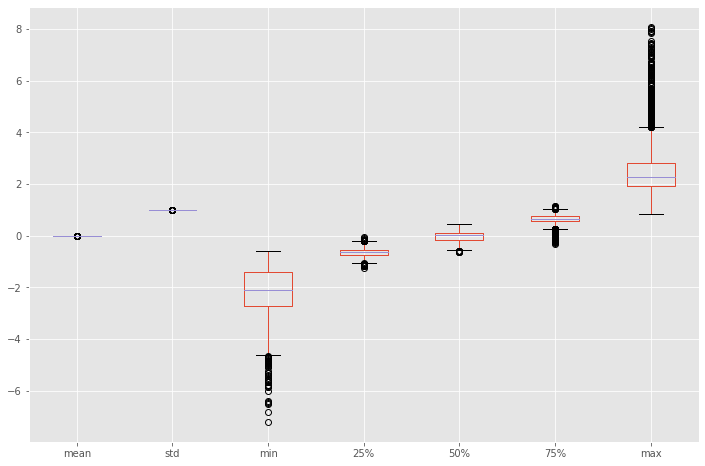

In [6]:
matplotlib.style.use('ggplot')
summary[['mean', 'std', 'min', '25%', '50%', '75%', 'max']].plot.box(return_type='axes', figsize=(12,8))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12148e198>,
      dtype=object)

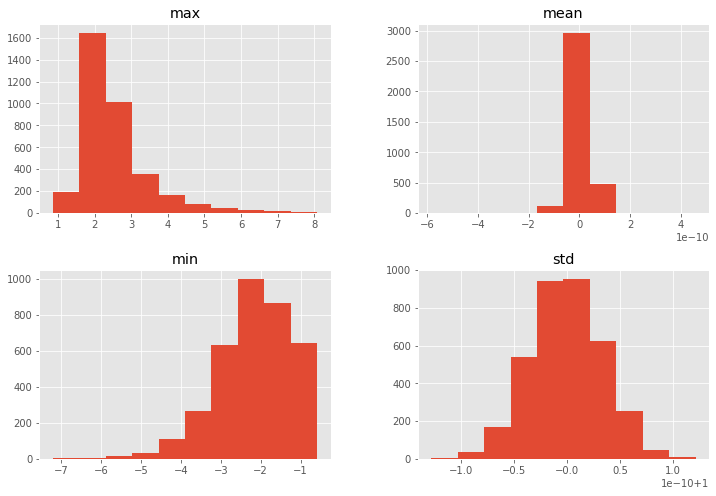

In [7]:
summary[['mean', 'std', 'min', 'max']].hist(figsize = (12,8))

In [8]:
labeled_data = pd.read_csv('https://web.stanford.edu/%7Ehastie/CASI_files/DATA/leukemia_small.csv')

In [9]:
# check for nan values
np.argwhere(df.isna().values).tolist()

[]

### Randomly split the AML / ALL leukemia dataset into training and test set

In [10]:
X = df.loc[:, 1:].values # gene expression data
y = df.loc[:, 0].values # label

df_values = df.loc[:, 1:].apply(pd.to_numeric).copy()

In [11]:
# create training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)
print(X_train.shape)
print(X_test.shape)

(50, 3571)
(22, 3571)


## Lasso, ridge and elastic net

Bias-Variance-Dilemma:
- bias (training error) and variance(complexity of the model) cannot be minimized at the same time
- look for tradeoff between bias and variance where total error is minimal
- yields the optimum model complexity

Regularization:
- discourages learning a more complex or flexible model to avoid the risk of overfitting

## Initialize Classifiers


In [12]:
ridge = LogisticRegression(penalty = 'l2', random_state=0, solver='lbfgs', l1_ratio = None)
lasso = LogisticRegression(penalty = 'l1', random_state=0, solver='liblinear', l1_ratio = None)
elasticNet = LogisticRegression(penalty = 'elasticnet', random_state=0, solver='saga', l1_ratio = 0.5) #class_weight={0: 1, 1: 2})

In [13]:
ridge.fit(X_train, y_train)
lasso.fit(X_train, y_train)
elasticNet.fit(X_train, y_train)

//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=0.5, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='elasticnet',
                   random_state=0, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

## Cross Validation

###  Use 5 fold cross validation to optimize each of the classifiers over a range of different regularization parameters using training data only

In [14]:
# alpha = regularization strength (lambda)
# for alpha = 0: same coefficients as for linear regression
# for alpha = ∞: coefficients = zero because anything less than zero will make the objective infinite
# for 0 < alpha < ∞: coefficients between 0 and 1 for simple linear regression

In [16]:
warnings.filterwarnings("ignore", category=DeprecationWarning) 


# define scores
scoring_mcc = metrics.make_scorer(
         metrics.matthews_corrcoef,
         greater_is_better=True,
         needs_threshold=False)

scoring = ['f1', scoring_mcc]
names = ['F1', 'MCC']

for score, name in zip(scoring, names):
    print('----------------------------')
    print(f'Score = {score}')
    print('----------------------------')
    for clf, name in zip([ridge, lasso, elasticNet], ['Ridge_CV', 'Lasso_CV','ElasticNet_CV']):
        # define parameters to be tested 
            # C = Inverse of regularization strength
            # l1_ratio = Elastic-Net mixing parameter
        if clf == elasticNet:
            param_grid = [{'C': np.logspace(-2, 5, 8), 'l1_ratio' : [i for i in np.arange(0.1, 1.1, 0.1)]}]
        else:      
            param_grid = [{'C': np.logspace(-2, 5, 8)}]
        clf = GridSearchCV(clf, param_grid, cv=5, scoring = score, n_jobs=-1)
        clf.fit(X_train, y_train)
        print(name)
        print()
        print("Best score for parameters set found on development set:")
        print(f'{clf.best_score_} for {clf.best_params_}')
        print()
        
    print('-----------------------------')



----------------------------
Score = f1
----------------------------
Ridge_CV

Best score for parameters set found on development set:
1.0 for {'C': 100.0}

Lasso_CV

Best score for parameters set found on development set:
1.0 for {'C': 1.0}



//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


ElasticNet_CV

Best score for parameters set found on development set:
1.0 for {'C': 0.1, 'l1_ratio': 1.0}

-----------------------------
----------------------------
Score = make_scorer(matthews_corrcoef)
----------------------------
Ridge_CV

Best score for parameters set found on development set:
1.0 for {'C': 100.0}

Lasso_CV

Best score for parameters set found on development set:
1.0 for {'C': 1.0}

ElasticNet_CV

Best score for parameters set found on development set:
1.0 for {'C': 0.1, 'l1_ratio': 1.0}

-----------------------------


//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


## Initialize classifiers with optimized parameters  ('C': 100.0, 'l1_ratio': 0.1)

In [17]:
ridge_cv = LogisticRegression(penalty = 'l2', random_state=0, solver='lbfgs', C = 100.0)
lasso_cv = LogisticRegression(penalty = 'l1', random_state=0, solver='liblinear', C = 1.0)
elasticNet_cv = LogisticRegression(penalty = 'elasticnet', random_state=0, solver='saga', C = 0.1, l1_ratio = 0.1)

In [18]:
ridge_cv.fit(X_train, y_train)
lasso_cv.fit(X_train, y_train)
elasticNet_cv.fit(X_train, y_train)

//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=0.1, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='elasticnet',
                   random_state=0, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

## Predictions on test set

In [19]:
def get_probability_estimates(X_test, y_test, models, names):
    '''
    return dataframe of probability estimates for models
    '''
    dic_probestimates = {}
    for model, name in zip(models, names):
        # predict y of test data
        y_pred = model.predict(X_test)
        probability_estimates = model.predict_proba(X_test)
        # take probability estimates for class 1
        probability_estimates_1 = probability_estimates[:,1]
        dic_probestimates[name] = probability_estimates_1    
    df_prob_estimates = pd.DataFrame(dic_probestimates)
    
    return df_prob_estimates

def get_y_predictions(X_test, y_test, models, names):
    '''
    return dataframe of y predictions for models
    '''
    dic_ypred = {}
    for model, name in zip(models, names):
        # predict y of test data
        y_pred = model.predict(X_test)
    
        dic_ypred[name] = y_pred    
        df_predictions = pd.DataFrame(dic_ypred)
    df_predictions['True'] = y_test
    
    return df_predictions

In [20]:
print('Probability Estimates for Ridge, Lasso and ElasticNet with and without Cross Validation\n')
df_prob_estimates = get_probability_estimates(X_test, y_test, [ridge, lasso, elasticNet, ridge_cv, lasso_cv, elasticNet_cv],
                                              ['Ridge','Lasso','ElasticNet', 'RidgeCV', 'LassoCV', 'ElasticNetCV'] )
df_prob_estimates.head()

Probability Estimates for Ridge, Lasso and ElasticNet with and without Cross Validation



,Ridge,Lasso,ElasticNet,RidgeCV,LassoCV,ElasticNetCV
0,0.017326,0.056502,0.475040,0.002309,0.056502,0.426994
1,0.711429,0.038167,0.947251,0.842936,0.038167,0.892885
2,0.020866,0.032663,0.444765,0.003519,0.032663,0.410236
3,0.000155,0.037223,0.067884,0.000002,0.037223,0.099355
4,0.810687,0.989451,0.981502,0.938798,0.989451,0.956796


In [21]:
print('Predicted y values for Ridge, Lasso and ElasticNet with and without Cross Validation\n')
df_predictions = get_y_predictions(X_test, y_test, [ridge, lasso, elasticNet, ridge_cv, lasso_cv, elasticNet_cv],
                                              ['Ridge','Lasso','ElasticNet', 'RidgeCV', 'LassoCV', 'ElasticNetCV'] )
df_predictions.head()

Predicted y values for Ridge, Lasso and ElasticNet with and without Cross Validation



,Ridge,Lasso,ElasticNet,RidgeCV,LassoCV,ElasticNetCV,True
0,0,0,0,0,0,0,0
1,1,0,1,1,0,1,1
2,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0
4,1,1,1,1,1,1,1


## Classification performance measure

Confusion matrix, without normalization
[[10  0]
 [ 2 10]]
Confusion matrix, without normalization
[[10  0]
 [ 1 11]]
Confusion matrix, without normalization
[[10  0]
 [ 4  8]]
Confusion matrix, without normalization
[[10  0]
 [ 4  8]]
Confusion matrix, without normalization
[[10  0]
 [ 0 12]]
Confusion matrix, without normalization
[[10  0]
 [ 0 12]]


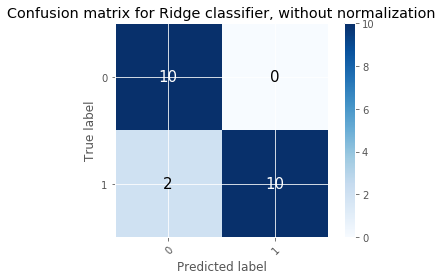

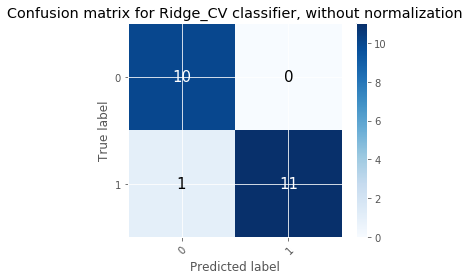

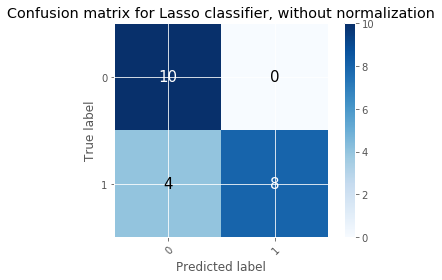

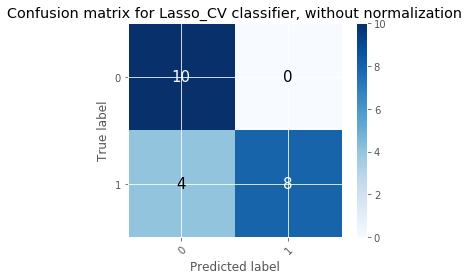

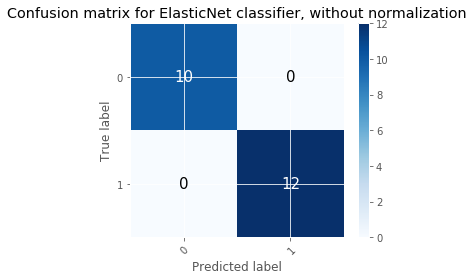

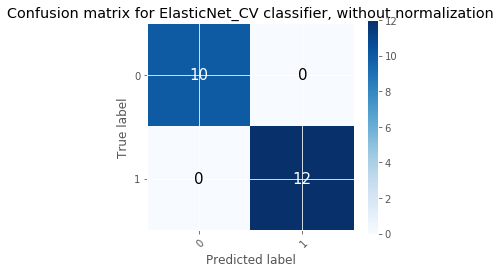

In [27]:
# Confusion matrix

for model, name in zip([ridge, ridge_cv, lasso, lasso_cv, elasticNet, elasticNet_cv],
                                              ['Ridge','Ridge_CV', 'Lasso','Lasso_CV', 'ElasticNet', 'ElasticNet_CV']):
    
    # predict y of test data
    y_pred = model.predict(X_test)

    
    # Plot non-normalized confusion matrix
    ax1_ = plot_confusion_matrix(df_predictions['True'], y_pred, classes=[0,1],
                       title=f'Confusion matrix for {name} classifier, without normalization')

    # Plot normalized confusion matrix
    #ax2_ = plot_confusion_matrix(df_predictions['True'], y_pred, classes=[0,1], normalize=True,
     #                     title=f'Normalized confusion matrix for {name} classifier')

In [26]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt), fontsize = 15,
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [ ]:
metrics.pre

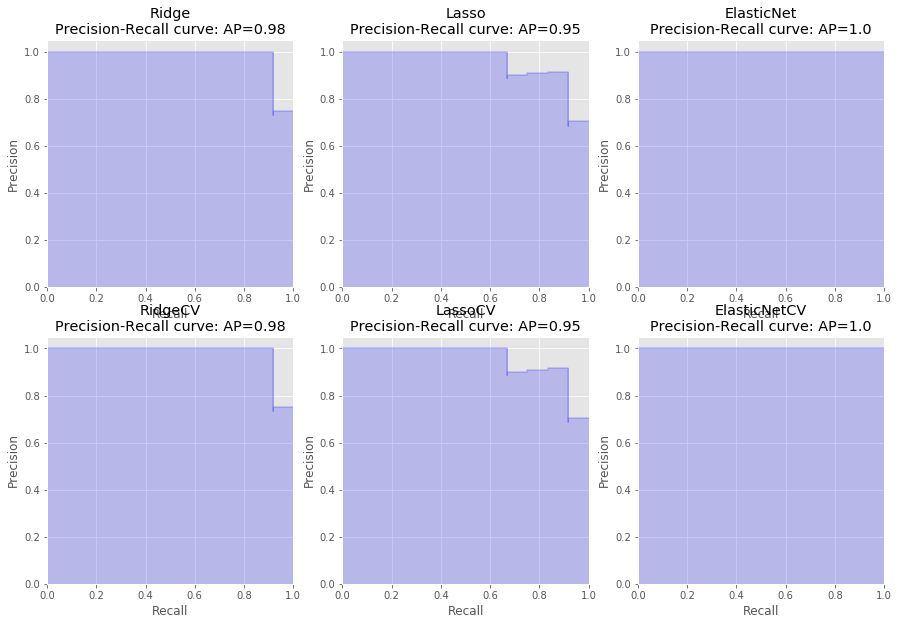

In [37]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
from inspect import signature


plt.figure(figsize=(15,10))
i = 1

for model, name in zip([ridge, lasso, elasticNet, ridge_cv, lasso_cv, elasticNet_cv],
                                              ['Ridge','Lasso','ElasticNet', 'RidgeCV', 'LassoCV', 'ElasticNetCV']):
    pos = int('23'+str(i))
    plt.subplot(pos)
    precision, recall, _ = precision_recall_curve(df_predictions['True'], df_prob_estimates[name])
    #print('precision ', precision)
    #print('recall ', recall)
    average_precision = metrics.average_precision_score(df_predictions['True'], df_prob_estimates[name])

    step_kwargs = ({'step': 'post'}
                   if 'step' in signature(plt.fill_between).parameters
                   else {})
    plt.step(recall, precision, color='b', alpha=0.2,
             where='post',)
    plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title(f'{name}\nPrecision-Recall curve: AP={average_precision:2.2}')
    i += 1
    
    


## Compare the performance of the ready optimized models on test data
### How much does the performance on test data differ from the CV performance achieved on training data?

In [38]:
dic_metrics = {}

for model, name in zip([ridge, ridge_cv, lasso, lasso_cv, elasticNet, elasticNet_cv],
                                              ['Ridge','RidgeCV', 'Lasso','LassoCV', 'ElasticNet', 'ElasticNetCV']):
    #recall = metrics.recall_score(df_predictions['True'], df_prob_estimates['ProbEstimate: '+name])
    #precision = metrics.precision_score(df_predictions['True'], df_prob_estimates['ProbEstimate: '+name])
    mcc = metrics.matthews_corrcoef(df_predictions['True'], df_predictions[name])
    f1_pos = metrics.f1_score(df_predictions['True'], df_predictions[name])
    f1_neg = metrics.f1_score(df_predictions['True'], df_predictions[name], pos_label = 0)
    precision = metrics.precision_score(df_predictions['True'], df_predictions[name])
    recall = metrics.recall_score(df_predictions['True'], df_predictions[name])
    dic_metrics[name] = {}
    dic_metrics[name]['MCC'] = mcc
    dic_metrics[name]['F1 pos'] = f1_pos
    dic_metrics[name]['F1 neg'] = f1_neg
df_metrics = pd.DataFrame(dic_metrics)
df_metrics

,Ridge,RidgeCV,Lasso,LassoCV,ElasticNet,ElasticNetCV
F1 neg,0.909091,0.952381,0.833333,0.833333,1.0,1.0
F1 pos,0.909091,0.956522,0.800000,0.800000,1.0,1.0
MCC,0.833333,0.912871,0.690066,0.690066,1.0,1.0


Matthews Correlation coefficient:

A coefficient of +1 represents a perfect prediction, 0 an average random prediction and -1 an inverse prediction

## Resources used:

https://towardsdatascience.com/regularization-in-machine-learning-76441ddcf99a

https://www.pluralsight.com/guides/linear-lasso-ridge-regression-scikit-learn

https://www.dataquest.io/blog/understanding-regression-error-metrics/

https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html#sphx-glr-auto-examples-model-selection-plot-precision-recall-py

